<a href="https://colab.research.google.com/github/usernamemadan/credit-card-fraud-detection/blob/master/intern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kaglekaglekagle","key":"00b188ebbf78607277ae0ac93c57f764"}'}

In [3]:
!cp kaggle.json ~/.kaggle/


In [4]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-29 17:43:56           6348  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           3646  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1275  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           2008  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [5]:
!kaggle datasets download -d mlg-ulb/creditcardfraud
!ls

 86% 57.0M/66.0M [00:00<00:00, 108MB/s] 
100% 66.0M/66.0M [00:00<00:00, 96.7MB/s]
creditcardfraud.zip  kaggle.json  sample_data


In [10]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn

In [8]:
import pandas as pd
data = pd.read_csv('/content/creditcardfraud.zip', compression='zip', header=0, sep=',', quotechar='"')

In [11]:
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [12]:
data.shape


(284807, 31)

In [25]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
169876,119907.0,-0.611712,-0.769705,-0.149759,-0.224877,2.028577,-2.019887,0.292491,-0.523020,0.358468,0.070050,-0.854023,0.547347,0.616448,-0.101785,-0.608492,-0.288559,-0.606199,-0.900746,-0.201311,-0.196039,-0.075208,0.045536,0.380739,0.023440,-2.220686,-0.201146,0.066501,0.221180,1.79,0
127467,78340.0,-0.814682,1.319219,1.329415,0.027273,-0.284871,-0.653985,0.321552,0.435975,-0.704298,-0.600684,0.096501,0.710309,0.778924,0.353867,0.953048,-0.103542,0.128899,-0.964070,-0.477130,-0.009041,-0.128619,-0.368565,0.090660,0.401147,-0.261034,0.080621,0.162427,0.059456,1.98,0
137900,82382.0,-0.318193,1.118618,0.969864,-0.127052,0.569563,-0.532484,0.706252,-0.064966,-0.463271,-0.528357,-0.813214,0.111898,1.133875,-0.649766,0.861035,0.583787,-0.344094,0.028312,0.219760,0.206028,-0.305402,-0.774704,-0.123884,-0.495687,-0.018148,0.121679,0.249050,0.092516,0.89,0
21513,31717.0,-1.328271,1.018378,1.775426,-1.574193,-0.117696,-0.457733,0.681867,-0.031641,0.383872,0.334853,0.905210,-0.277872,-1.336179,-0.012238,0.212828,0.769345,-1.010534,0.357288,-0.125585,0.315823,-0.220815,-0.419013,-0.239197,0.009967,0.232829,0.814177,0.098797,-0.004273,15.98,0
134700,80923.0,1.276712,0.617120,-0.578014,0.879173,0.061706,-1.472002,0.373692,-0.287204,-0.084482,-0.696578,0.101512,-0.433200,-0.634867,-1.188354,1.028063,0.576121,1.068353,0.332690,-0.362811,-0.105286,-0.160161,-0.430404,-0.076738,0.258708,0.552170,0.370701,-0.034255,0.041709,0.76,0


In [24]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,56961.00000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000
mean,94571.23811,0.007759,-0.007820,0.010548,0.004755,-0.011918,0.002191,-0.011845,0.000873,0.007915,0.002185,-0.004426,-0.003849,0.001368,0.002554,0.001640,0.001307,0.007001,0.003073,-0.001168,0.001871,0.002932,0.003058,-0.001127,-0.001869,0.000662,0.002157,0.000632,-0.002841,88.750996,0.001527
std,47566.88462,1.944402,1.654560,1.495860,1.415369,1.379057,1.329111,1.209897,1.160905,1.093541,1.067004,1.017789,0.991854,0.996799,0.945133,0.915855,0.873080,0.837536,0.837648,0.816278,0.759775,0.723614,0.723845,0.654303,0.603150,0.519287,0.481474,0.393477,0.302685,254.652038,0.039052
min,0.00000,-46.855047,-63.344698,-31.813586,-5.266509,-42.147898,-23.496714,-26.548144,-33.785407,-8.739670,-18.271168,-4.110261,-18.553697,-4.008640,-18.049998,-4.196620,-12.675269,-25.162799,-9.042845,-7.213527,-23.420173,-16.640785,-10.933144,-36.666000,-2.836627,-7.025783,-2.534330,-8.260909,-9.617915,0.000000,0.000000
25%,53809.00000,-0.915616,-0.607161,-0.883553,-0.843085,-0.707818,-0.765759,-0.563241,-0.206358,-0.632800,-0.532743,-0.759871,-0.414383,-0.649076,-0.423878,-0.583304,-0.468572,-0.479784,-0.498752,-0.459078,-0.212990,-0.227125,-0.541228,-0.162431,-0.356802,-0.316805,-0.324992,-0.071111,-0.053391,5.950000,0.000000
50%,84511.00000,0.033625,0.061363,0.185144,-0.012678,-0.071228,-0.270147,0.030874,0.024519,-0.044122,-0.089537,-0.033737,0.137494,-0.016244,0.048926,0.052428,0.065159,-0.062709,-0.004680,-0.000518,-0.063154,-0.029706,0.010522,-0.010926,0.038833,0.017169,-0.049862,0.001250,0.010776,22.160000,0.000000
75%,139237.00000,1.318624,0.800511,1.031245,0.750016,0.605042,0.403820,0.558736,0.327343,0.605625,0.461624,0.731950,0.615230,0.667584,0.493618,0.652043,0.524359,0.405384,0.500456,0.459776,0.134297,0.186236,0.531158,0.148271,0.434270,0.350835,0.243869,0.089448,0.076211,77.900000,0.000000
max,172784.00000,2.411499,17.418649,4.069865,16.715537,34.099309,22.529298,36.677268,19.587773,10.370658,12.901627,11.228470,4.403899,4.369998,7.421944,5.825654,6.351853,9.253526,5.041069,5.228342,39.420904,22.588989,6.090514,18.946734,3.962197,5.541598,3.155327,11.135740,15.373170,19656.530000,1.000000


In [14]:
# random_state helps assure that you always get the same output when you split the data
# this helps create reproducible results and it does not actually matter what the number is
# frac is percentage of the data that will be returned
data = data.sample(frac = 0.2, random_state = 1)
print(data.shape)

(56961, 31)


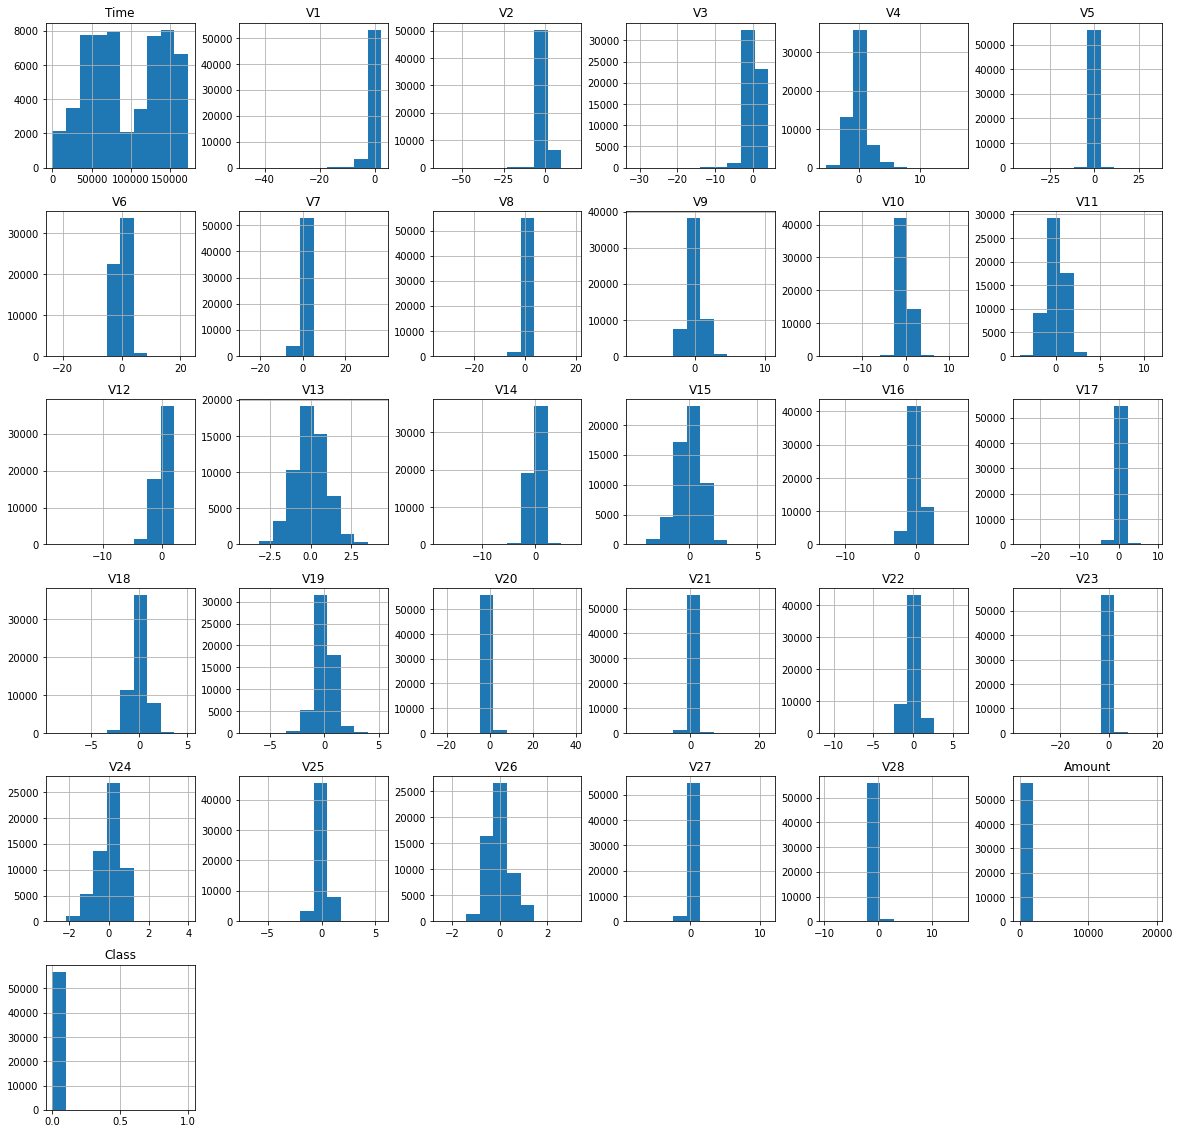

In [15]:
# plot the histogram of each parameter
data.hist(figsize = (20, 20))
plt.show()

In [16]:
# determine the number of fraud cases
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]

outlier_fraction = len(fraud) / float(len(valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(fraud)))
print('Valid Cases: {}'.format(len(valid)))

0.0015296972254457222
Fraud Cases: 87
Valid Cases: 56874


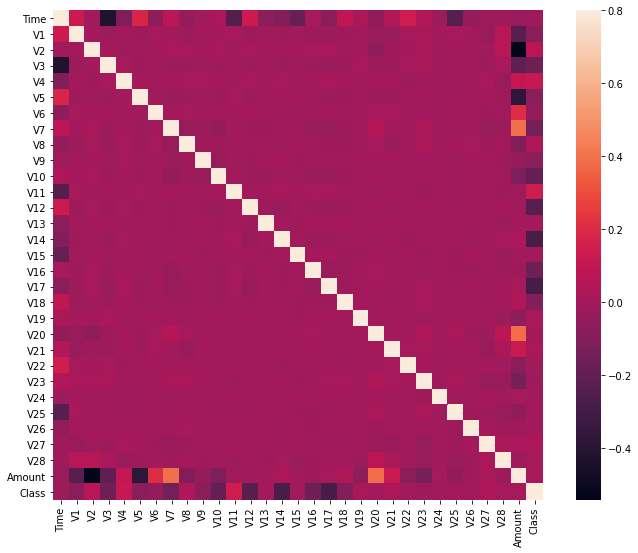

In [17]:
# correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [18]:
# get the columns from the dataframe
columns = data.columns.tolist()

# filter the columns to remove the data we do not want
columns = [c for c in columns if c not in ['Class']]

# store the variable we will be predicting on which is class
target = 'Class'

# X includes everything except our class column
X = data[columns]
# Y includes all the class labels for each sample
# this is also one-dimensional
Y = data[target]

# print the shapes of X and Y
print(X.shape)
print(Y.shape)

(56961, 30)
(56961,)


In [20]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [21]:
# define a random state
state = 1

# define the outlier detection methods
classifiers = {
    # contamination is the number of outliers we think there are
    'Isolation Forest': IsolationForest(max_samples = len(X),
                                       contamination = outlier_fraction,
                                       random_state = state),
    # number of neighbors to consider, the higher the percentage of outliers the higher you want to make this number
    'Local Outlier Factor': LocalOutlierFactor(
    n_neighbors = 20,
    contamination = outlier_fraction)
}

In [22]:
n_outliers = len(fraud)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == 'Local Outlier Factor':
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    # reshape the prediction values to 0 for valid and 1 for fraud
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1

    # calculate the number of errors
    n_errors = (y_pred != Y).sum()
    
    # classification matrix
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))

Isolation Forest: 129
0.9977352925685996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.26      0.26      0.26        87

    accuracy                           1.00     56961
   macro avg       0.63      0.63      0.63     56961
weighted avg       1.00      1.00      1.00     56961

Local Outlier Factor: 173
0.9969628342199048
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.01      0.01      0.01        87

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

